
# LatticeRegister Tutorial (QCOM)

This notebook is a quick, practical guide to using `LatticeRegister` for building explicit lattice-site layouts that plug directly into QCOM Hamiltonian builders.

**What you'll learn**  
1. Create a register (empty or with initial positions)  
2. Add/remove sites & inspect indices  
3. Read-only vs. copy semantics (`.positions` vs `.as_array()`)  
4. Compute distances (single & pairwise)  
5. Plotting (auto 2D/3D) + optional interactivity  
6. Resetting with `.clear()`  



## Contents
1. [Setup](#setup)  
2. [Create a register](#create)  
3. [Add sites & view index map](#add)  
4. [Positions view vs. copy](#views)  
5. [Remove sites](#remove)  
6. [Distances](#distances)  
7. [Plotting (2D/3D)](#plotting)  
8. [Interactivity (optional)](#interactive)  
9. [Clear the register](#clear)  


## 1) Setup  <a id='setup'></a>

First, make sure you have the **QCOM** package installed.  
If it’s not already installed in your Python environment, you can do so with:

```bash
pip install qcom
```

Once installed, the recommended way to import is directly from the package:

```python
from qcom.lattice_register import LatticeRegister
import numpy as np
import matplotlib.pyplot as plt
```

> **Why this import?**  
> Importing from the submodule (`qcom.lattice_register`) is explicit and future-proof. It won’t break if the package’s top-level exports change later.

**Alternative forms you may see in examples:**

- **Re-exported (convenience) style** — works today because `qcom.__init__` re-exports `LatticeRegister`:
  ```python
  import qcom as qc
  reg = qc.LatticeRegister()
  ```
  *Note:* This is convenient, but slightly less stable if module exports change in a future release.


In [1]:
from qcom.lattice_register import LatticeRegister
import numpy as np
import matplotlib.pyplot as plt

## 2) Create a register  <a id='create'></a>


> Note: Python classes can define special “dunder” methods like __len__.   
> $\quad \quad$ For LatticeRegister, len(register) is the intended way to check size, but it simply calls __len__() behind the scenes.



In [2]:
# Start with an empty register
register = LatticeRegister()

# The idiomatic way to check the number of sites:
length = len(register)

# (For curiosity) This is equivalent under the hood:
length_dunder = register.__len__()

print(f"Number of sites in the register: {length} (same as __len__(): {length_dunder})")

Number of sites in the register: 0 (same as __len__(): 0)


## 3) Add sites & view index map  <a id='add'></a>

Indexing is **insertion order**: the first site you add gets index 0, the next gets index 1, and so on.  

By **QCOM convention**, site **0 corresponds to the most significant bit (MSB)** in the computational basis.  

> **Example:**  
> If you add 3 sites in order `A, B, C`, then:  
> - Site 0 → MSB  
> - Site 1 → middle bit  
> - Site 2 → LSB  
>
> A bitstring like `101` means:  
> - Site 0 (MSB) = 1 (excited)  
> - Site 1 = 0 (ground)  
> - Site 2 (LSB) = 1 (excited)  

This convention makes it unambiguous to map bitstrings ↔ sites when analyzing results.

In [3]:
# Build a simple 2D square in the x-y plane (z=0): 4 sites
register.add((0.0e-6, 0.0e-6, 0.0e-6))  # 0
register.add((1.0e-6, 0.0e-6, 0.0e-6))  # 1
register.add((0.0e-6, 1.0e-6, 0.0e-6))  # 2
register.add((1.0e-6, 1.0e-6, 0.0e-6))  # 3

print(register.index_map())

index  x (m)           y (m)           z (m)
-----  --------------  --------------  --------------
0        0.000000e+00    0.000000e+00    0.000000e+00
1        1.000000e-06    0.000000e+00    0.000000e+00
2        0.000000e+00    1.000000e-06    0.000000e+00
3        1.000000e-06    1.000000e-06    0.000000e+00


## 4) Positions **view** vs **copy**  <a id='views'></a>

- `.positions` returns a **read-only view** of the internal array (attempting to modify raises an error).  
- `.as_array()` returns a **copy** you can modify without affecting the register.

> **Note:** The only way to change the register is via class methods (e.g., `.add()`, `.remove()`, `.clear()`).


In [4]:
# Read-only view (will raise if you try to modify in place)
view = register.positions
# shape should be (num_sites, 3) where 3 is the (x,y,z) coords
print('view shape:', view.shape, '| writeable:', view.flags['WRITEABLE'])

# Safe copy
arr = register.as_array()
arr[0, 0] = 123.0  # OK (does not affect the register)
print('modified copy first x:', arr[0,0])
print('original first x     :', register.positions[0,0])

view shape: (4, 3) | writeable: False
modified copy first x: 123.0
original first x     : 0.0


## 5) Remove sites  <a id='remove'></a>

Removal is **by index** to maintain unambiguous mapping to bitstrings.

> **Note:** If you do not remember the index of the site you wish to remove simply call **.index_map()** as shown previously.


In [5]:
removed = register.remove(1)  # remove site with index 1
print('removed index:', removed)
print(register.index_map())

removed index: 1
index  x (m)           y (m)           z (m)
-----  --------------  --------------  --------------
0        0.000000e+00    0.000000e+00    0.000000e+00
1        0.000000e+00    1.000000e-06    0.000000e+00
2        1.000000e-06    1.000000e-06    0.000000e+00


## 6) Distances  <a id='distances'></a>

You can get a single pair distance or the full pairwise distance matrix (in meters).

> **Note:** Distances are reported in meters.  
> For typical lattice geometries, values are ~microns (1e-6 m) or nanometers (1e-9 m).  
> If you see a matrix of all zeros, make sure suppress_small=False in the print settings.   
> This prevents NumPy from rounding very small numbers to 0.0.


In [6]:
d_0_2 = register.distance(0, 2)
D = register.distances()
print('distance(0,2) =', d_0_2, 'm')

# note: the matrix should have dimensions (num_sites, num_sites)
# we use suppress_small=False because in SI units site separations may be ~1e-6 or smaller.
# setting suppress_small=True will round these to 0.0, which can be misleading.
print('pairwise distances (m):\n',
      np.array_str(D, precision=5, suppress_small=False, max_line_width=100))

distance(0,2) = 1.414213562373095e-06 m
pairwise distances (m):
 [[0.00000e+00 1.00000e-06 1.41421e-06]
 [1.00000e-06 0.00000e+00 1.00000e-06]
 [1.41421e-06 1.00000e-06 0.00000e+00]]


## 7) Plotting (2D/3D)  <a id='plotting'></a>

- If **all z = 0**, the plot is 2D.  
- If **any z ≠ 0**, the plot automatically switches to 3D.  


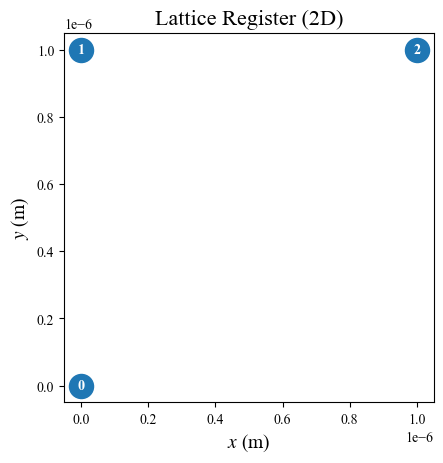

In [7]:
# 2D example (all z=0) — annotate indices
ax = register.plot(show_index=True, s=300)  # you can pass kwargs to matplotlib's scatter via **kwargs
plt.show()

index  x (m)           y (m)           z (m)
-----  --------------  --------------  --------------
0        0.000000e+00    0.000000e+00    0.000000e+00
1        0.000000e+00    1.000000e-06    0.000000e+00
2        1.000000e-06    1.000000e-06    0.000000e+00
3        5.000000e-07    5.000000e-07    1.000000e-06
4        1.500000e-06    5.000000e-07    2.000000e-06


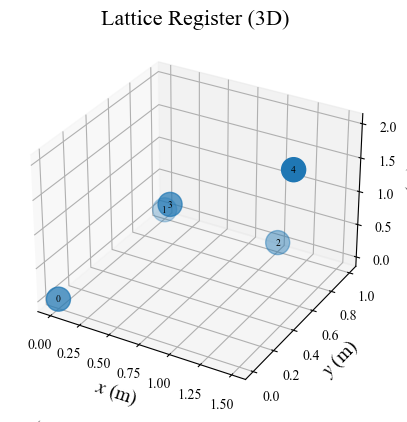

In [8]:
# Make it 3D by adding sites with nonzero z
register.add((0.5e-6, 0.5e-6, 1.0e-6))
register.add((1.5e-6, 0.5e-6, 2.0e-6))

print(register.index_map())
ax = register.plot(show_index=True, s=300)
plt.show()

## 8) Interactivity (optional)  <a id='interactive'></a>

For interactive rotation in notebooks:
- Install once: `pip install ipympl`
- In a notebook cell, run **before plotting**:
```python
%matplotlib widget
```
Then call `register.plot()` — you'll be able to rotate the 3D axes.

> **Note:** Enabling %matplotlib widget changes how all plots behave in the notebook (2D and 3D).  
This can sometimes cause odd behavior with figure sizing or scrolling, depending on your Jupyter environment.  
If you run into issues, switch back with 
```Python
%matplotlib inline
```


## 9) Clear the register  <a id='clear'></a>

In [9]:
register.clear()
print('N after clear =', len(register))

N after clear = 0
